In [1]:
import re
import numpy as np
import pandas as pd
import calendar
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cmlib
import matplotlib.ticker as plticker
import datetime as dt2
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.weightstats as smS
from dython.nominal import associations

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import MeanShift
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFpr

import tensorflow_decision_forests as tfdf
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import confusion_matrix


WMN = 'WMN'
UNKNOWN = 'UNK'
OTHER = 'Other'

AC, FB ='AC','FB'
PE, ALK = 'PE','ALK'
PVC = 'PVC'
CI, CLCI, DI, ELCI, CLDI, GI = 'CI','CLCI', 'DI', 'ELCI', 'CLDI','GI'
IRON='Iron'

MAX_PERCEN_TOSHOW = 2

MAX_PRERanges='PreMax_Range'
LBL_MAX_PRE = 'Max pressure (m)'
LBL_PRE_FLU = 'Pressure fluctuation (m)'

INSERV_PROCESS = 'In Service'
MATERIALS_PREDOMI = [AC,PVC,IRON,PE]

Age_Range = np.arange(0, 115, 5).tolist()
AgeR_labels = [str(i) for i in np.arange(0, 110, 5).tolist()]

Diam_bins = [25 ,75, 115, 135, 165, 190, 225,275,800]
DRange_labels = ['50', '100', '125','150','175','200','250','>300']

PressMax_bins = [20,50,60,70,80,90,120]
PMaxRange_labels = ['(20,50]','(50,60]','(60,70]','(70,80]','(80,90]','(90,120]']

PressFluc_bins = [0,5,10,15,100]
PFlucRange_labels = ['(0,5]','(5,10]','(10,15]','(15,100]']

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)
plt.rcParams['legend.facecolor'] = 'white'

In [2]:
def getAssetsRecords():

    fname = 'Data/Assets/001-All-Assets_1.csv'
    fname2 = 'Data/Assets/001-All-Assets_2.csv'
    fname3 = 'Data/Assets/001-All-Assets_3.csv'

    AllAssets = pd.read_csv(fname, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets2 = pd.read_csv(fname2, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets3 = pd.read_csv(fname3, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])

    AllAssetsCom = AllAssets.append(AllAssets2).append(AllAssets3).copy()

    WaterMain = AllAssetsCom[AllAssetsCom['Asset Type Code'] == WMN].copy()

    print("There are ", WaterMain.shape[0], " water mains in the database (NOT GIS)")

    waterMains = WaterMain[~WaterMain.index.duplicated(keep='first')]

    print("There are ", WaterMain.shape[0], " water mains not duplicated in the database (NOT GIS)")
    
    #rename the index
    waterMains.index.names = [COMPKEY]

    return waterMains


def getFailureRecords(fname,numFailureRecordsOri):
    #Reads the cvs file result from the query to the Watercare DB and store it in a dataframe
    failureRecords = pd.read_csv(fname, delimiter = ',', 
                                 usecols=[0,1,7,9,8,5],
                                 dtype = {WONO:'str', ACTCODE:'str',SERVNO:'str',WC.SR_PROB:'str',
                                          ADDDTTM:'str', COMPKEY:'int64'},
                                 index_col=0,
                                 parse_dates=[ADDDTTM],
                                )[[SERVNO,ACTCODE,WC.SR_PROB,ADDDTTM,COMPKEY]]
    numFailureRecordsOri= failureRecords.shape[0]
    print('Number of records from the DB query:' , numFailureRecordsOri)

    failureRecords= failureRecords[~failureRecords.index.duplicated()].copy()

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records duplicated WONO: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]

    #For this study if it is the same type of Repair activity on the same asset associated 
    #to the same service number and in the same date 
    #The duplicated values are due diferencees in the contractor reference numbers used to add parts of the costs.
    #therefore the duplicates are not necesary unless the cost is needed
    failureRecords.drop_duplicates(inplace=True)

    #check for duplicates using only the date (not datetime) in the extraMethods.py file!!

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    return failureRecords, numFailureRecordsOri

def getFilterCodesAndSR() :

	fileACTCODE = 'Data/01-ACTCODERepair.csv'
	fileSR_Prob = 'Data/02-SR_PROB_TO_FILTER.csv'

	#read the filter files
	ACTCODERepair = pd.read_csv(fileACTCODE)
	SR_ToFilter = pd.read_csv(fileSR_Prob)

	return ACTCODERepair, SR_ToFilter

def filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair, numFailureRecordsOri):
	#filters the service codes related to third parties---------------------------------------------------------------
    failureRecords= failureRecords[~failureRecords[WC.SR_PROB].isin(SR_ToFilter['SR_PROB_TO_FILTER'])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' 3P Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]


	#filters the activities with actcodes not related to repairs------------------------------------------------------
    failureRecords= failureRecords[failureRecords[ACTCODE].isin(ACTCODERepair[ACTCODE])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' Not repair Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    
    return failureRecords, numFailureRecordsOri

def getAddressFromFailureRecords(fname):

	addressRecords = pd.read_csv(fname, delimiter = ',', 
								usecols=[0,12,13,14,15,16,17],
								dtype = {WONO:'str', 'Street_Type':'str','Street_Name':'str',SUBURB:'str',
								'FLAT':'str','HOUSENO':'str','POSTCODE':'str'})

	addressRecords.drop_duplicates(inplace=True)
	addressRecords.set_index(WONO, inplace=True, drop=True)

	return addressRecords

def filterFailuresbyInconsistentAddress(failures, addressRecords, assetAddresses):

	#adds the compkeys to the addressess of the failure table 
    failAddr= failures.join(addressRecords)[[COMPKEY,'Street_Type','Street_Name',SUBURB]]
    failAddr=failAddr.astype({COMPKEY: 'int64'})

	#creates the table to compare addresses 
    addrComp= failAddr.join(assetAddresses, on=COMPKEY)

	#compare the suburbs and drop the values that dont match
    indexToFilter= addrComp[addrComp[SUBURB].str.upper()!=addrComp[SUBURB].str.upper()].index
    failures.drop(indexToFilter , inplace=True)
    
    return failures

def getFailuresWithPipes(mainFailures, WMNFromAssetRecordsIndex):

	fWPipes = 'Data/00-Water_Pipe.csv'

	wPipesGIS = pd.read_csv(fWPipes, delimiter = ',', 
		                                dtype = {COMPKEY:'int64',STATUS:'str',MATERIAL:'str',
		                                         NOM_DIA_MM:'str',INSTALLED:'str',
                                                 'Shape_Leng' : 'float64'},
		                                usecols=[2,8,9,11,12,18],
		                                parse_dates=[INSTALLED],
		                                index_col=[COMPKEY]
		                                )

	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " length ", "%.2f" % wPipesGIS['Shape_Leng'].sum())
	originalGIS = wPipesGIS.shape[0]
    
    #merge duplicates compkeys
	wPipesGIS = wPipesGIS.groupby(wPipesGIS.index).agg({'Shape_Leng':sum, STATUS: 'first', NOM_DIA_MM: 'first', MATERIAL : 'first', INSTALLED:'first'})
	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " total length ", "%.2f" % wPipesGIS['Shape_Leng'].sum(),". Removed COMPKEY duplicates: ", originalGIS - wPipesGIS.shape[0])
	originalGIS = wPipesGIS.shape[0]
	
	#Delete no main pipes by the all assets dataset
	wPipesGIS = wPipesGIS[wPipesGIS.index.isin(WMNFromAssetRecordsIndex)].copy()
	print("Records of main pipes (GIS) ",  wPipesGIS.shape[0], ". Removed pipes with all assets WMN: ", originalGIS - wPipesGIS.shape[0])
	
    
	#look for the pipes of the failures and create a table with number of failure per pipe
	mainF_GISPipes= mainFailures.join(wPipesGIS, on= COMPKEY).copy()
	failuresWithPipesMissingInGIS = mainF_GISPipes[pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	failuresWithPipesInGIS = mainF_GISPipes[~pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	print('Failures with pipes in the GIS ', failuresWithPipesInGIS.shape[0], '. Failures with pipes missing in GIS ', failuresWithPipesMissingInGIS.shape[0])


	return failuresWithPipesInGIS, wPipesGIS


def manage_GISPipes(mainFailures,WMNFromAssetRecordsIndex):

    failuresWithPipesInGIS, wPipesGIS = getFailuresWithPipes(mainFailures,WMNFromAssetRecordsIndex)

    countNumFPerPipe = failuresWithPipesInGIS.groupby([COMPKEY]).agg({SERVNO: 'count', ACTCODE : 'first'})
    countNumFPerPipe.rename(columns={SERVNO:'Num of failures'}, inplace= True)


    #asign the number of failures per pipe including 0 to all the main pipe table and change formats
    wPipesGIS[NOM_DIA_MM] = pd.to_numeric(wPipesGIS[NOM_DIA_MM],errors='coerce')
    wPipesGISNfailures = wPipesGIS.join(countNumFPerPipe[['Num of failures']])
    wPipesGISNfailures["Num of failures"].fillna(0, inplace=True)
    wPipesGISNfailures["Age Today"] = (pd.to_datetime('today').tz_localize('UTC')-pd.to_datetime(wPipesGISNfailures["INSTALLED"])).astype('<m8[Y]')
    
    #calculates the age of failure and removes incorrect values
    failuresWithPipesInGIS["Age at failure"] = (pd.to_datetime(failuresWithPipesInGIS["ADDDTTM"].dt.tz_localize(None)) 
    - pd.to_datetime(failuresWithPipesInGIS["INSTALLED"]).dt.tz_localize(None)).astype('<m8[Y]')
    
    failuresWithPipesInGIS= failuresWithPipesInGIS[failuresWithPipesInGIS["Age at failure"]>=0].copy()
    
    for df in [failuresWithPipesInGIS,wPipesGISNfailures]:
        
        df['Shape_Leng'] = df['Shape_Leng']/1000 #pass to km
        df[MATERIAL] = df[MATERIAL].replace(UNKNOWN, np.nan)
        df[NOM_DIA_MM].fillna(0, inplace=True)

        #Combine AC
        df[MATERIAL] = df[MATERIAL].replace(FB, AC)

        #Combine PE
        df[MATERIAL] = df[MATERIAL].replace(ALK, PE)

        #combine CI
        df[MATERIAL] = df[MATERIAL].replace(CLCI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(DI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(ELCI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(CLDI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(GI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(CI, IRON) 

    return wPipesGISNfailures, failuresWithPipesInGIS


# -------------------- CONST --------------------

In [3]:
def getMaterialConst():
    
    fmaterialsConst='Data/Const-Materials.csv'

    materialsConst = pd.read_csv(fmaterialsConst, delimiter = ',', index_col=[MATERIAL])
    
    return materialsConst

def getDiameterConst():
    
    fdiameterConst='Data/Const-Diameter.csv'

    diameterConst = pd.read_csv(fdiameterConst, delimiter = ',', index_col=[DIAMETER])
    
    return diameterConst

def getAgeConst():
    
    fageConst='Data/Const-Ages.csv'

    ageConst = pd.read_csv(fageConst, delimiter = ',', index_col=['Age'])
    
    return ageConst

In [4]:
def getBase():
    
    fname = 'Data/03-WorkOrders.csv'
    numFailureRecordsOri = 0

    failureRecords , numFailureRecordsOri = getFailureRecords(fname,numFailureRecordsOri)
    ACTCODERepair, SR_ToFilter = getFilterCodesAndSR()

    failureRecords , numFailureRecordsOri = filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair,numFailureRecordsOri)

    #divide between MAIN and SERViCE LINES------------------------------------------------
    mainFailures = failureRecords[(failureRecords[ACTCODE]=='WMNRM') | (failureRecords[ACTCODE]=='WMNRPL')].copy()

    numFailRecordsOriM = mainFailures.shape[0]

    print('Number of failures in Mains :', numFailRecordsOriM)

    addressFromFailureRecords = getAddressFromFailureRecords(fname)
    WMNFromAssetRecords = getAssetsRecords()

    mainFailures = filterFailuresbyInconsistentAddress(mainFailures, addressFromFailureRecords, WMNFromAssetRecords)
    print('Number of failures in Mains :', mainFailures.shape[0], ' Different address Deleted records: ', numFailRecordsOriM - mainFailures.shape[0])

    numFailRecordsOriM=mainFailures.shape[0]

    #returns the shape_length in km
    wPipesGISNfailures, failuresWithPipesInGIS = manage_GISPipes(mainFailures,WMNFromAssetRecords.index.tolist())

    
    #remove non predominan materials  and sort them 
    predoMaterials = wPipesGISNfailures[wPipesGISNfailures[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
    predoMaterials.MATERIAL = pd.Categorical(predoMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
    predoMaterials=predoMaterials.sort_values(MATERIAL).copy()

    failuresPMaterials= failuresWithPipesInGIS[failuresWithPipesInGIS[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
    failuresPMaterials.MATERIAL = pd.Categorical(failuresPMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
    failuresPMaterials=failuresPMaterials.sort_values(MATERIAL).copy()
    
    return predoMaterials, failuresPMaterials


predoMaterials, failuresPMaterials = getBase()
consCoM = getMaterialConst()['Color']
pal=[consCoM[m] for m in MATERIALS_PREDOMI]

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 558467  3P Deleted records:  12481
Number of failure records: 92691  Not repair Deleted records:  465776
Number of failures in Mains : 14735


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
Number of failures in Mains : 13107  Different address Deleted records:  1628
Records of pipes (GIS)  619384  length  11486294.71
Records of pipes (GIS)  612465  total length  11486294.71 . Removed COMPKEY duplicates:  6919
Records of main pipes (GIS)  212535 . Removed pipes with all assets WMN:  399930
Failures with pipes in the GIS  13057 . Failures with pipes missing in GIS  50


# --------------------INTRINSIC CHARACTERISTICS ANALYSIS--------------------

In [5]:
def putInRanges(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol):
    
    df[colRanges]= pd.cut(df[col], bins=bins, labels=labels)
    #remove invalid values (nulls)----------------------------------
    dfOK= df[~pd.isna(df[colRanges])].copy()
    
    if getValidationVals is not None:
        const= getValidationVals()
        for i in const.index:
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]<const.loc[i, startCol])].index)
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]>const.loc[i,finishCol])].index)
    
    print("(Main in service) Pipe length with valid ",col+" ","%.2f" % dfOK['Shape_Leng'].sum()," from original ", "%.2f" % df['Shape_Leng'].sum())
    
    return dfOK


def getValidationYears():
    
    consYears = getMaterialConst()[['YearIni','YearFinal']]
    consYears = consYears[consYears.index.isin(MATERIALS_PREDOMI)]
    consYears['StartAge'] = 2021-consYears['YearIni'] 
    consYears['EndAge'] = 2021-consYears['YearFinal']
    consYears['EndAge'].replace(0, np.nan, inplace=True)
    consYears.index = pd.Categorical(consYears.index,categories= MATERIALS_PREDOMI)
    consYears=consYears.sort_index()
    
    return consYears


# From soil analysis -------------------------------------------------------------------

In [6]:
def joinWithGeoUnits(df):
    
    #Geounits 
    fGeoUnits = 'Data/Geounits/Geounits.csv'
    geoUnits = pd.read_csv(fGeoUnits, delimiter = ',', usecols=['main_rock'])
    
    #Water pipes FID
    fWaterPipesGISIDs = 'Data/Geounits/Water_pipes.csv'
    waterPipesGISIDs = pd.read_csv(fWaterPipesGISIDs, delimiter = ',', dtype = {COMPKEY:'int64'}, 
                                   usecols=[COMPKEY])
    print("Number of water pipe records ", waterPipesGISIDs.shape[0])

    #Intersections using FIDs
    fGeoUnitsIPipes = 'Data/Geounits/IntersectGeounitsVsWaterP.csv'
    geoUnitsIPipes = pd.read_csv(fGeoUnitsIPipes, delimiter = ',', dtype = {'FID_Water_':'int64'},
                                        usecols=[1,2,3],index_col=['FID_Water_'])
    print("Number of intersections " , geoUnitsIPipes.shape[0] , " so 1.7% extra")
    
    #joins the geounits interception to the id compkey table obtaining (COMPKEY,FID_NZL_GN) then eliminate the 
    pipesCKGeoUnitsID = waterPipesGISIDs.join(geoUnitsIPipes)
    
    #join the atributes of the geo units
    pipesCKGeoUnits = pipesCKGeoUnitsID.join(geoUnits, on='FID_250KGe').copy()
    assert pipesCKGeoUnitsID.shape[0] == pipesCKGeoUnits.shape[0] #check that the join was done correctly
    pipesCKGeoUnits = pipesCKGeoUnits.replace(" ", np.nan).copy()
    
    
    pipesGeounits= pipesCKGeoUnits.sort_values('Shape_Leng',ascending=False).drop_duplicates([COMPKEY],keep='first').set_index(COMPKEY)
    
    #//------------------------------------
    
    sizeO = df.shape[0]
    dfNSoil = df.join(pipesGeounits[['main_rock']].copy())
    
    assert sizeO == dfNSoil.shape[0] #check that the join was done correctly
    assert sizeO == len(dfNSoil.index.unique()) #there are not repeated COMPKEYS
    
    return dfNSoil


# From climate analysis ---------------------------------------------------------------

In [7]:
def getClimateData():

    fclimate='Data/Climate/00-ClimateInfoFinal.csv'

    climate = pd.read_csv(fclimate, delimiter = ',')
    
    climate= climate.replace('-', np.nan).copy()
    climate.loc[:,"Jan":"Dec"]= climate.loc[:,"Jan":"Dec"].astype(float,errors = 'raise').copy()

    climateTemp = climate[climate['Stats_Code']==2].copy()
    climateRainFall= climate[climate['Stats_Code']==0].copy()
    climateDefic= climate[climate['Stats_Code']==66].copy()
    
    return climateTemp,climateRainFall,climateDefic


def getPipesVsStations(df):
    
    fcliStaVsPipes='Data/Climate/05-WaterPipes_NearTablesClimate.txt'
    cliStaVsPipes = pd.read_csv(fcliStaVsPipes, delimiter = ',',usecols=[3,22,23,24,25],index_col=[COMPKEY])
    #remove duplicate compkeys 
    cliStaVsPipes= cliStaVsPipes.groupby(cliStaVsPipes.index).agg({'Rain_Dist': 'first', 'Rain_ID': 'first',
                                                   'NEAR_FID': 'first', 'NEAR_DIST': 'first'}).copy()

    fcliStaTemp='Data/Climate/04-StationsTemperature.txt'
    cliStaTemp = pd.read_csv(fcliStaTemp, delimiter = ',',usecols=[0,2,3,12],dtype = {'Agent_Numb':'Int64'},
                             index_col=['FID'])[['Agent_Numb']]
    cliStaTemp.rename(columns={'Agent_Numb':'Station Temperature'},inplace=True)
    
    fcliStaRain='Data/Climate/03-StationsRain.txt'
    cliStaRain = pd.read_csv(fcliStaRain, delimiter = ',',usecols=[0,2,3,12],dtype = {'Agent_Numb':'Int64'},
                             index_col=['FID'])[['Agent_Numb']]
    cliStaRain.rename(columns={'Agent_Numb':'Station Rain'},inplace=True)
    
    pipesVsStations = df.join(cliStaVsPipes)
    
    pipesVsStations = pipesVsStations.join(cliStaTemp,on='NEAR_FID')
    pipesVsStations = pipesVsStations.join(cliStaRain,on='Rain_ID')
     
    assert pipesVsStations.shape[0] == df.shape[0]
    
    return pipesVsStations


# Start from Pressure analysis --------------------------------------------------------

In [8]:
def getFailuresWithPressures(df):

	# Join by vicinity of the shape file "Water_Pipe" from Nish with the file of preassures from Mike
    fGISPipesPressure = 'Data/09-JoinWater_PipeVsPressure.csv'

    GISpipesVsPressures = pd.read_csv(fGISPipesPressure, delimiter = ',', 
	                            dtype = {COMPKEY:'int64', 'MOD_MAXPRE':'float64','MOD_MINPRE':'float64','Press_fluc':'float64',
                                        'Distance': 'float64'},
								usecols=[3,25,26,38,39,35],
	                            index_col=[COMPKEY])

    GISpipesVsPressures = GISpipesVsPressures.groupby(GISpipesVsPressures.index).agg({'MOD_MAXPRE': 'mean', 'MOD_MINPRE': 'mean',
                                                                                      'Press_fluc': 'mean', 'Distance': 'mean',
                                                                                     'MODEL_NAME': 'first'})

    wPipesGISNfailuresPressure = df.join(GISpipesVsPressures)
    print("Total Length of pipes with pressure (GIS)", "%.2f" % wPipesGISNfailuresPressure['Shape_Leng'].sum(), " in ",  wPipesGISNfailuresPressure.shape[0], "records")
    assert df.shape[0] == wPipesGISNfailuresPressure.shape[0]
    
    #remove pipes without near nodes
    dfNPressures= wPipesGISNfailuresPressure[wPipesGISNfailuresPressure['Distance']<5].copy()
    print("Total Length of pipes with VALID distance to pressure (GIS)", "%.2f" % dfNPressures['Shape_Leng'].sum(), " in ",  dfNPressures.shape[0], "records")

    
    #modify the names so they match with waterModelExtent 
    dfNPressures['MODEL_NAME']= dfNPressures['MODEL_NAME'].replace('_',' ', regex=True).str.title()
    dfNPressures['MODEL_NAME']=dfNPressures['MODEL_NAME'].replace({'Greenhithe Kyle':'Greenhithe & Kyle',
                                                    'Snells Algies' :'Snells & Algies','Gptk':'GPTK','Acg':'ACG',
                                                    'Okhd':'OKHD', 'Takg':'TAKG','Cbd':'CBD'})
    
    return dfNPressures

# Start Coordinates analysis ----------------------------------------------------

In [9]:
def getCoordinates(df):

    # Join by vicinity of the shape file "Water_Pipe" from Nish 
    fGISPipesCoord = 'Data/Coordinates/CoordinatesMiddlePointAll.txt'

    GISPipesCoord = pd.read_csv(fGISPipesCoord, delimiter = ',',
                               dtype = {COMPKEY:'int64', 'LAT':'float64','LONG':'float64'},
                                usecols=[3,24,25],
                                index_col=[COMPKEY])

    GISPipesCoord = GISPipesCoord.groupby(GISPipesCoord.index).agg({'LAT': 'first', 'LONG': 'first'})

    dfNCoordinates = df.join(GISPipesCoord)
    print("Total Length of pipes with coordinates (GIS)", "%.2f" % dfNCoordinates['Shape_Leng'].sum(), " in ",  dfNCoordinates.shape[0], "records")
    assert df.shape[0] == dfNCoordinates.shape[0]
    
    print("MaxLat:",dfNCoordinates['LAT'].max(),"MinLat:",dfNCoordinates['LAT'].min())
    print("MaxLong:",dfNCoordinates['LONG'].max(),"MinLong:",dfNCoordinates['LONG'].min())
     
    return dfNCoordinates

def joinWithSuburbs(df, address):
    
    dfWithAddress = df.join(address[[SUBURB]], on=COMPKEY)
    
    assert dfWithAddress.shape[0] == df.shape[0] #check that the join was done correctly
    
    
    return dfWithAddress
      

# From all matrix analysis ----------------------------------------------------

In [10]:
def validateIntrinsicValues(df):
    
    print("Before intrinsic values cleaning ", df.shape[0])
    
    df[NOM_DIA_MM]= df[NOM_DIA_MM].where(df[NOM_DIA_MM]>Diam_bins[0], np.nan)
    df[NOM_DIA_MM]= df[NOM_DIA_MM].where(df[NOM_DIA_MM]<=Diam_bins[len(Diam_bins)-1], np.nan)
       
    df= df.drop([STATUS,"Num of failures"], axis=1)
    
    const= getValidationYears()
    
    for i in const.index:
        
        ini=const.loc[i, "StartAge"]
        fin=const.loc[i, "EndAge"]
        
        condI= ~((df.MATERIAL == i) & (df['Age Today']>ini))
        condF= ~((df.MATERIAL == i) & (df['Age Today']<fin))
        df['Age Today'] = df['Age Today'].where(condI, np.nan)
        df['Age Today'] = df['Age Today'].where(condF, np.nan)
        
    df.dropna(inplace=True)
    
    df= df[['Shape_Leng',NOM_DIA_MM,'Age Today',MATERIAL,INSTALLED]]

    print("After intrinsic values cleaning ", df.shape[0] )
      
    return df


#Gets a table of records failures columns values of the pipe and climate of the failure month
def joinWithClimate(dfPipes):
    
    climateVals= getClimateData()
    
    #Get the station of each pipe
    dfPipesS=getPipesVsStations(dfPipes).copy()
    dfPipesS.drop(['Rain_Dist','Rain_ID','NEAR_FID','NEAR_DIST'], axis=1, inplace=True)
    assert dfPipesS.shape[0] == dfPipes.shape[0]
    
    for climate, sta,v in zip(climateVals,['Station Temperature','Station Rain','Station Rain'],
                             ["Temp M(max-min)","Rain M(max-min)","SMD M(max-min)"]):
       
        cli=climate.rename(columns={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7, 'Aug':8,
                                'Sep':9,'Oct':10,'Nov':11,'Dec':12, 'Station': sta,'Year ':"Year"})

        cli=cli.drop(['Stats_Code','Annual'], axis=1).set_index([sta,'Year']).copy()
        
        cli[v]= cli.max(axis=1)-cli.min(axis=1)
        cli= cli.reset_index().groupby([sta]).agg({v:'mean'}).copy()
        
        #Join pipes with climate
        dfPipesS= dfPipesS.join(cli, on=sta).copy()
        assert dfPipes.shape[0] == dfPipesS.shape[0]
        
    dfPipesS.drop(['Station Temperature','Station Rain'], axis=1,inplace=True)
    
    dfPipesS.dropna(inplace=True)
    
    print("After cleaning Climate ", dfPipesS.shape[0])

    return dfPipesS

def joinWithPressure(dfMains):
    
    #join with pressure (remove pressures that dont have a point near)
    dfMP= getFailuresWithPressures(dfMains)
    
    #validate pressures
    dfMP['MOD_MAXPRE'] = dfMP['MOD_MAXPRE'].where(dfMP['MOD_MAXPRE']>PressMax_bins[0], np.nan)
    dfMP['MOD_MINPRE'] = dfMP['MOD_MINPRE'].where(dfMP['MOD_MINPRE']>PressMax_bins[0], np.nan)
    dfMP['MOD_MAXPRE'] = dfMP['MOD_MAXPRE'].where(dfMP['MOD_MAXPRE']<=PressMax_bins[len(PressMax_bins)-1], np.nan)
    dfMP['MOD_MINPRE'] = dfMP['MOD_MINPRE'].where(dfMP['MOD_MINPRE']<=PressMax_bins[len(PressMax_bins)-1], np.nan)
    
    dfMP.dropna(inplace=True)
    dfMP.drop(columns=['Distance','MODEL_NAME','MOD_MINPRE'], inplace=True)
    
    print("After cleaning pressures ", dfMP.shape[0])
    
    return dfMP


#modified!!
def joinWithLocation(df):
    
    #join with coordinates
    dfM= getCoordinates(df)
    
    dfM.dropna(inplace=True)
    print("After cleaning coordinates ", dfM.shape[0])
    
    #join with suburb
    WMNFromAssetRecords = getAssetsRecords()
    dfM= joinWithSuburbs(dfM, WMNFromAssetRecords)
    
    dfM.dropna(inplace=True)
    print("After cleaning suburbs ", dfM.shape[0])
    
    return dfM

def joinWithMainRock(df):
    
    dfM= joinWithGeoUnits(df)
    
    dfM.dropna(inplace=True)
    print("After cleaning geounits ", dfM.shape[0])
    
    return dfM
    


In [11]:
def joinWithValues(dfMains, ann=False):
    
    dfMains= validateIntrinsicValues(dfMains) #diameter , current age and material
     
    dfMains= joinWithPressure(dfMains) #max and fluctuation
    
    dfMains=joinWithLocation(dfMains) #coordinates and suburb
    
    dfMains= joinWithMainRock(dfMains) #main rock
    
    dfMains=dfMains.rename(columns={NOM_DIA_MM:DIAMETER,MATERIAL:MATERIAL,'MOD_MAXPRE':'MaxPressure',
                                    'MOD_MINPRE':'MinPressure','Press_fluc':'PressureFluc',
                                    'main_rock':'SoilMainRock','Age Today': 'Current age'})
     
    return dfMains
 

def scalateVariables(df,sca):
    
    df["Material"] = df["Material"].astype("str")
    dfDis= df.select_dtypes(exclude=['object',]).copy()
    dfCate= df.select_dtypes(include=['object']).copy()
    
    scaler = sca.fit(dfDis)
    transformation = scaler.transform(dfDis)
    
    dfDis70= dfDis[dfDis['Current age']==70].iloc[0:1,:].copy()
    print("70 years would be ", scaler.transform(dfDis70)[0,3], dfDis.columns.tolist()[3])
    dfScaled = pd.DataFrame(data=transformation, columns=dfDis.columns.tolist(), index=dfDis.index.tolist())
    
    dfAll= dfCate.join(dfScaled).copy()
    
    return dfAll

def getDummies(df):
    
    dfWithDummies = pd.get_dummies(df)
    
    return dfWithDummies
    

In [12]:
def expandDfPerMonth(df):

    sdate=dt2.date(2013, 3, 1)
    edate=dt2.date(2020, 1, 1)
    dates= pd.date_range(sdate,edate,freq='M')
    ori= df.shape[0]

    df['Month']= 2
    df['Year']= 2013
    auxO=df.copy()

    for d in dates:

        auxC= auxO.copy()
        auxC['Month']= d.month
        auxC['Year']= d.year
        df=df.append(auxC)
    
    assert df.shape[0] == ori*(len(dates)+1)
        
    return df


def joinWithFailuresMonthly(dfMains,failures):
    
    #filter pipes that were filtered from dfMAins compared to dfFailAll (failures)
    dfFailures= failures[failures[COMPKEY].isin(dfMains.index.tolist())].copy()
    
    #Modify the dfFailures to leve only one row per pipe , month and year of failure
    dfFailures["Month"]= dfFailures[ADDDTTM].dt.month
    dfFailures["Year"]= dfFailures[ADDDTTM].dt.year
    dfFail= dfFailures.groupby(["COMPKEY","Year","Month"]).agg({ADDDTTM: 'count'}).copy()
    dfFail.rename(columns={"ADDDTTM": "MonthFailures"},inplace=True)
    
    assert dfFailures.shape[0] == dfFail['MonthFailures'].sum()

    #Expands the dfMains to mains x each month in the evaluation period (2014-2020)
    df=expandDfPerMonth(dfMains)
    df.set_index(['Month',"Year"], append=True,inplace=True) #adds month and year to compkey
    
    #join with number of failures
    dfN=df.join(dfFail).copy()
    dfN['MonthFailures']=dfN['MonthFailures'].fillna(0)
    assert df.shape[0] == dfN.shape[0]
    assert dfFailures.shape[0] == dfN['MonthFailures'].sum() 
    
    return dfN

#Gets a table of records failures columns values of the pipe and climate of the failure month
def addClimateToAll(dfPipes,dfMonthlyPipes):
    
    climateVals= getClimateData()
    
    #Get the station of each pipe
    dfStations=getPipesVsStations(dfPipes)[['Station Temperature','Station Rain']].copy()
    
    #Attach the stations to the all
    dfAllSta= dfMonthlyPipes.join(dfStations)
    assert dfMonthlyPipes.shape[0] == dfAllSta.shape[0]
    
    for climate, sta,v in zip(climateVals,['Station Temperature','Station Rain','Station Rain'],
                             ["Temperature","Rain","SMD"]):
       
        cli=climate.rename(columns={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7, 'Aug':8,
                                'Sep':9,'Oct':10,'Nov':11,'Dec':12, 'Station': sta,'Year ':"Year"})

        cli=cli.drop(['Stats_Code','Annual'], axis=1).set_index([sta,'Year']).copy()
        cli=pd.melt(cli,var_name="Month",value_name=v,ignore_index = False)
        
        cli.set_index(['Month'], append=True,inplace=True)

        
        #Join pipesDates with climate
        dfAllSta= (dfAllSta.reset_index().set_index([sta,'Month','Year'])).join(cli).copy()
        assert dfMonthlyPipes.shape[0] == dfAllSta.shape[0]
        
    dfAllFinal= dfAllSta.reset_index().drop(columns=['Station Temperature','Station Rain'])
    
    #deletes months without values
    #dfAllFinal.dropna(inplace=True)
    
    return dfAllFinal

def getMonthlyFailureRecords(dfPipesAll,dfPipes,failures,climate=True):

    dfMonthly= joinWithFailuresMonthly(dfPipesAll,failures)
    
    print("Started with " ,dfMonthly.shape[0], " monthly values and ", len(dfMonthly.reset_index()[COMPKEY].unique()),
         " pipes")
      
    #creates the date
    dfMonthly["day"] = 1
    dates= dfMonthly.reset_index().rename(columns={"Month": "month", "Year": "year"})[["day","month",'year']]
    dfMonthly["Date"]= pd.to_datetime(dates).values
    
    dfMonthly["MonthsOld"] = (pd.to_datetime(dfMonthly["Date"]).dt.to_period("M").astype('int')
                            - pd.to_datetime(dfMonthly["INSTALLED"]).dt.to_period("M").astype('int'))
    
    #six months but one extra so it doesnt take the present month ----------
    rollingMonthF=dfMonthly.groupby("COMPKEY").rolling('210D', on="Date",closed='left')["MonthFailures"].sum() 
    passFailures = rollingMonthF.reset_index()
    passFailures["Month"]= passFailures['Date'].dt.month
    passFailures["Year"]= passFailures['Date'].dt.year
    passFailures=passFailures.set_index([COMPKEY,'Month','Year']).drop(columns=['Date']).rename(columns={"MonthFailures": "Past6MonthsTFail"})

    dfMonthlyPass=dfMonthly.join(passFailures)

    assert dfMonthlyPass.shape[0] == dfMonthly.shape[0]
    #-----------------
    
    #add climate
    if climate:
        dfMonthlyFinal= addClimateToAll(dfPipes,dfMonthlyPass)
    
        print("Finished (after adding climate) with " ,dfMonthlyFinal.shape[0], " monthly values and ", len(dfMonthlyFinal.reset_index()[COMPKEY].unique()),
         " pipes")
    else:
        dfMonthlyFinal= dfMonthlyPass
    
                               
    dfMonthlyFinal = dfMonthlyFinal.drop(columns=['day','Current age',INSTALLED])
    
    dfMonthlyFinal = dfMonthlyFinal[dfMonthlyFinal['MonthsOld']>0].copy()
    
    return dfMonthlyFinal

def getFeaturesTransformed(df,material=False):
    
    #scalate time
    year = (365.2425)*24*60*60
    
    #divide by training and testing, use the last year as test 
    indLastMonths= (df['Date']>=pd.Timestamp('2019-1-1'))
    dfTraining= df[~indLastMonths].copy()
    dfTesting= df[indLastMonths].copy()

    for dfi in [dfTraining,dfTesting]:
        
        #add the date scalated 
        yearsInSec= dfi['Date'].map(pd.Timestamp.timestamp)
        
        dfi['YearSin'] = np.sin(yearsInSec * (2 * np.pi / year))
        dfi['YearCos'] = np.cos(yearsInSec * (2 * np.pi / year))
        
        #Drop columns
        dfi.drop(columns= [MATERIAL,'Date','Year'],inplace=True)
        
    
    print("Finished creating the transformed data ---------------------------")
    
    return dfTraining, dfTesting


In [13]:
def getBaseRandomForest(pipes,fails,dfM):
        
    print("Start with ", dfM.shape[0])
    
    #Get the monthly records
    dfMonthly= getMonthlyFailureRecords(dfM.copy(),pipes.copy(),fails.copy(),True)
    
    #change types keras requires the y as int, and nothing else as int
    dfMonthly['MonthFailures']=dfMonthly['MonthFailures'].astype(int)
    dfMonthly['Failed']= np.where(dfMonthly['MonthFailures']>0 ,1,0)
    
    #Put the weights
    total= dfMonthly['MonthFailures'].count()
    vals=pd.DataFrame(dfMonthly['MonthFailures'].value_counts())
    vals['weights']= (1/vals['MonthFailures'])*(total/2.0)
    
    dfMonthly= dfMonthly.join(vals[['weights']],on='MonthFailures').copy()
    dfMonthly.drop(columns=['MonthFailures'],inplace=True)
    
    #transforms the data
    dfTraining, dfTesting= getFeaturesTransformed(dfMonthly.copy(),True)
    
    return dfTraining, dfTesting

In [14]:
predoMaterials, failuresPMaterials = getBase()

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 558467  3P Deleted records:  12481
Number of failure records: 92691  Not repair Deleted records:  465776
Number of failures in Mains : 14735


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
Number of failures in Mains : 13107  Different address Deleted records:  1628
Records of pipes (GIS)  619384  length  11486294.71
Records of pipes (GIS)  612465  total length  11486294.71 . Removed COMPKEY duplicates:  6919
Records of main pipes (GIS)  212535 . Removed pipes with all assets WMN:  399930
Failures with pipes in the GIS  13057 . Failures with pipes missing in GIS  50


In [15]:
# Target column name.
TARGET_COLUMN_NAME = "Failed"
# Weight column name.
WEIGHT_COLUMN_NAME = "weights"

# Numeric feature names.
NUMERIC_FEATURE_NAMES = [ 
    "Diameter",
    "MaxPressure",
    "PressureFluc",
    "MonthsOld",
    "YearSin",
    "YearCos", 
    "Shape_Leng",
    "Past6MonthsTFail",
    "Temperature",
    "Rain",
    "SMD",
    'LAT', 
    'LONG'
]

CATEGORICAL_FEATURE_NAMES = [
    "Month",
    "SoilMainRock",
    "Suburb"
]

#ALL COPYED FROM https://keras.io/examples/structured_data/classification_with_tfdf/

def prepare_dataframe(dataframe):
   
    # Cast the categorical features to string.
    for feature_name in CATEGORICAL_FEATURE_NAMES:
        dataframe[feature_name] = dataframe[feature_name].astype(str)


def run_experiment(model, train_data, test_data, num_epochs=1, batch_size=None):

    train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        train_data, label=TARGET_COLUMN_NAME, weight=WEIGHT_COLUMN_NAME
    )
    test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        test_data, label=TARGET_COLUMN_NAME, weight=WEIGHT_COLUMN_NAME
    )

    model.fit(train_dataset, epochs=num_epochs, batch_size=batch_size)
    evalu = model.evaluate(test_dataset, verbose=0)
    print("Eval: ", evalu)
    
    train_pred = model.predict(train_dataset)
    test_pred = model.predict(test_dataset)
    
    return train_pred, test_pred

def specify_feature_usages():
    feature_usages = []

    for feature_name in NUMERIC_FEATURE_NAMES:
        feature_usage = tfdf.keras.FeatureUsage(
            name=feature_name, semantic=tfdf.keras.FeatureSemantic.NUMERICAL
        )
        feature_usages.append(feature_usage)

    for feature_name in CATEGORICAL_FEATURE_NAMES:
        feature_usage = tfdf.keras.FeatureUsage(
            name=feature_name, semantic=tfdf.keras.FeatureSemantic.CATEGORICAL
        )
        feature_usages.append(feature_usage)

    return feature_usages

In [93]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def create_RForestmodel():
    
    # Specify the model.
    modelRF = tfdf.keras.RandomForestModel(
                    features=specify_feature_usages(),
                    exclude_non_specified_features=True,
                     missing_value_policy= "LOCAL_IMPUTATION",
                     growing_strategy="BEST_FIRST_GLOBAL",
                    num_trees=900)

    # Optionally, add evaluation metrics.
    modelRF.compile(metrics=METRICS)

    return modelRF


def create_GradientBoostedModel():
    
    modelGB = tfdf.keras.GradientBoostedTreesModel(
        growing_strategy="BEST_FIRST_GLOBAL",
        num_trees=900,
        max_depth=10,
        subsample=0.9,
        shrinkage=0.05,
        features=specify_feature_usages(),
        exclude_non_specified_features=True,
        missing_value_policy= "LOCAL_IMPUTATION") 
    
    modelGB.compile(metrics=METRICS)
    
    return modelGB


In [17]:
def trainNetwork(dTr, dTe, RF):

    if RF:
        model = create_RForestmodel()
    else:
        model = create_GradientBoostedModel()
    
    trainPred, testPred = run_experiment(model, dTr, dTe)

    return model, trainPred, testPred
    

In [74]:
def plot_cm(labels, predictions,m, p=0.5,RF=True):
    
    cm = confusion_matrix(labels>p, predictions>p,normalize='true')
    fig1, ax  = plt.subplots(figsize=(6,6))
    
    labs= ["Not failed", "Failed"]
    sns.heatmap(cm, ax=ax, annot=True, xticklabels=labs,yticklabels=labs)
    #plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    name= ('ConfusionMatrix'+ m +'.png') if RF else ('ConfusionMatrix'+ m + "Boost"+'.png')
        
    fig1.savefig('Maps_Graph/CorrelationAnalysis/'+ name , dpi=200, bbox_inches='tight')
    
    cm = confusion_matrix(labels>p, predictions>p)
    
    print('Fails predicted (True Positives): ', cm[1][1])
    print('False fails (False Positives): ', cm[0][1])
    print('Not Fails (True Negatives): ', cm[0][0])
    print('Fails not predicted (False Negatives): ', cm[1][0])
    
    print('Total fails: ', np.sum(cm[1]))

In [88]:
global TrdS

def trainAllModels(RF):
    
    models = []
    trPredicted = []
    tePredicted = []
    testVar = []
    
    df= joinWithValues(predoMaterials.copy())
    
    for m in MATERIALS_PREDOMI:
        
        print("Started with ", m)
        
        dfM=df[df["Material"]==m].copy()
        
        dfTrain, dfTest= getBaseRandomForest(predoMaterials.copy(),failuresPMaterials.copy(),dfM)
        
        print("Started forest with (training) " ,dfTrain.shape[0], " monthly values and ", len(dfTrain.reset_index()[COMPKEY].unique()),
         " pipes")
        print("Started forest with (test) " ,dfTest.shape[0], " monthly values and ", len(dfTest.reset_index()[COMPKEY].unique()),
         " pipes")
    
        #global TrdS
        #TrdS= dfTrain.copy()
        prepare_dataframe(dfTrain)
        prepare_dataframe(dfTest)
        
        mod, trPred, tePred = trainNetwork(dfTrain, dfTest,RF)
        
        print("Finish training with features :", mod.make_inspector().features())
        
        models.append(mod)
        trPredicted.append(trPred)
        tePredicted.append(tePred)
        testVar.append(dfTest)
        
    return models,trPredicted,tePredicted,testVar
        

In [77]:
def plotAllModelsResults(dfOri,ypre,dfPipes,matP,RF=True):
    
    for m,km in zip([0,1,2,3], matP.kmReplace.values.tolist()):
        
        df= dfOri[m]
        
        #for graph
        print("size test", df.shape[0], " vs predict ", len(ypre[m]))
        
        df['Predicted'] = ypre[m] > 0.5
        resultsComp= df.groupby([COMPKEY]).agg({'Failed': sum, 'Predicted': sum}) #count in the year
         
        plot_cm(resultsComp['Failed'],resultsComp['Predicted'], MATERIALS_PREDOMI[m],0.5, RF)
        
        #for list
        df['PredictedRaw'] = ypre[m]
        
        #failedTrue= resultsComp[resultsComp['Failed']>0].copy()
        resMax= df.groupby([COMPKEY]).agg({'PredictedRaw': max}
                                           ).sort_values(by=['PredictedRaw'],ascending=False) # max in the year
        
        
        priorityP= dfPipes.reindex(resMax.index)
     
        #get the number of pipes that doesnt sum more than the km given in the parameter
        print("Target replaced KM", km)
        priorityPAtt= priorityP[np.less_equal(priorityP.Shape_Leng.cumsum().values, km)]
        
        #failedTrue.to_csv('Output/Regressions/'+"RFPredictedTrue"+MATERIALS_PREDOMI[m]+'.csv')
        name= "RF" if RF else "GBDT"
        priorityPAtt.to_csv('Output/Regressions/'+"ReplacementList"+name+MATERIALS_PREDOMI[m]+'.csv')
        
        
        #deprecated --
        #resSum= df.groupby([COMPKEY]).agg({'PredictedRaw': sum}
        #                                  ).sort_values(by=['PredictedRaw'],ascending=False) # sum in the year
        #highestNFailures= resultsComp[resultsComp['Predicted']>0].copy()
        
        #resSum.to_csv('Output/Regressions/'+"RFFirst1000Sum"+MATERIALS_PREDOMI[m]+'.csv')
        #highestNFailures.to_csv('Output/Regressions/'+"highestFailures"+MATERIALS_PREDOMI[m]+'.csv')
    

In [21]:
totalReplace = predoMaterials.Shape_Leng.sum()/100
matPropo= failuresPMaterials.groupby([MATERIAL]).agg({SERVNO: 'count'})
matPropo['%'] = matPropo[SERVNO]/ matPropo[SERVNO].sum()*100
matPropo['kmReplace'] = matPropo['%'] * totalReplace/100

In [101]:
def getImportances(models):
    
    print("NUM_NODES: Number of nodes using a specific feature. The larger")
    print("NUM_AS_ROOT: Number of root nodes using a specific feature. The larger")
    print("SUM_SCORE: Sum of the split scores using a specific feature. The larger")
    print("MEAN_MIN_DEPTH: Average minimum depth of the first occurence of a feature across all the tree paths. The smaller")

    for mo, ma in zip(models,MATERIALS_PREDOMI):
        
        print("Material: " , ma, " ----------------------------------------------")
        importances= mo.make_inspector().variable_importances()
        
        for i in importances:
            dfIm= pd.DataFrame(importances[i],columns=['var', i]).set_index('var')
            print(dfIm)
        
        #print(mo.make_inspector().features())
        

In [94]:
#Random forest
#Test with climate manejo de nulls + optimizar + more trees 
modelsResultRF, trPredictedResultRF,tePredictedResultRF, testVarResultRF = trainAllModels(RF=True)

Before intrinsic values cleaning  198694
After intrinsic values cleaning  193348
Total Length of pipes with pressure (GIS) 8918.57  in  193348 records
Total Length of pipes with VALID distance to pressure (GIS) 6969.23  in  141403 records
After cleaning pressures  139477
Total Length of pipes with coordinates (GIS) 6871.76  in  139477 records
MaxLat: 1774083.89002 MinLat: 1727604.1138599997
MaxLong: 5986639.7981 MinLong: 5874217.251150001
After cleaning coordinates  139477


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
After cleaning suburbs  139477
Number of water pipe records  619384
Number of intersections  629931  so 1.7% extra
After cleaning geounits  139395
Started with  AC
Start with  44665
Started with  3707195  monthly values and  44665  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished (after adding climate) with  3707195  monthly values and  44665  pipes
Finished creating the transformed data ---------------------------
Started forest with (training)  3171215  monthly values and  44665  pipes
Started forest with (test)  535980  monthly values and  44665  pipes
49551/49551 [==============================] - 206s 4ms/step
Eval:  [0.0, 698.0, 204420.0, 330745.0, 117.0, 0.6183868646621704, 0.003402919275686145, 0.8564417362213135, 0.8183321952819824, 0.0068969810381531715]
Finish training with features : ["Diameter" (1; #0), "LAT" (1; #1), "LONG" (1; #2), "MaxPressure" (1; #3), "Month" (4; #4), "MonthsOld" (1; #5), "Past6MonthsTFail" (1; #6), "PressureFluc" (1; #7), "Rain" (1; #8), "SMD" (1; #9), "Shape_Leng" (1; #10), "SoilMainRock" (4; #11), "Suburb" (4; #12), "Temperature" (1; #13), "YearCos" (1; #14), "YearSin" (1; #15)]
Started with  PVC
Start with  28276
Started with  2346908  monthly values and  28276  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished (after adding climate) with  2346908  monthly values and  28276  pipes
Finished creating the transformed data ---------------------------
Started forest with (training)  2000617  monthly values and  28276  pipes
Started forest with (test)  339312  monthly values and  28276  pipes
31260/31260 [==============================] - 137s 4ms/step
Eval:  [0.0, 1062.0, 320592.0, 553454.0, 184.0, 0.6335211396217346, 0.0033016845118254423, 0.8523274660110474, 0.8192278146743774, 0.0066887629218399525]
Finish training with features : ["Diameter" (1; #0), "LAT" (1; #1), "LONG" (1; #2), "MaxPressure" (1; #3), "Month" (4; #4), "MonthsOld" (1; #5), "Past6MonthsTFail" (1; #6), "PressureFluc" (1; #7), "Rain" (1; #8), "SMD" (1; #9), "Shape_Leng" (1; #10), "SoilMainRock" (4; #11), "Suburb" (4; #12), "Temperature" (1; #13), "YearCos" (1; #14), "YearSin" (1; #15)]
Started with  Iron
Start with  31198
Started with  2589434  monthly values and  31198  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished (after adding climate) with  2589434  monthly values and  31198  pipes
Finished creating the transformed data ---------------------------
Started forest with (training)  2207857  monthly values and  31198  pipes
Started forest with (test)  374376  monthly values and  31198  pipes
34498/34498 [==============================] - 147s 4ms/step
Eval:  [0.0, 1219.0, 453844.0, 794393.0, 212.0, 0.6366586685180664, 0.0026787500828504562, 0.8518518805503845, 0.8268551826477051, 0.0063219862058758736]
Finish training with features : ["Diameter" (1; #0), "LAT" (1; #1), "LONG" (1; #2), "MaxPressure" (1; #3), "Month" (4; #4), "MonthsOld" (1; #5), "Past6MonthsTFail" (1; #6), "PressureFluc" (1; #7), "Rain" (1; #8), "SMD" (1; #9), "Shape_Leng" (1; #10), "SoilMainRock" (4; #11), "Suburb" (4; #12), "Temperature" (1; #13), "YearCos" (1; #14), "YearSin" (1; #15)]
Started with  PE
Start with  35256
Started with  2926248  monthly values and  35256  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished (after adding climate) with  2926248  monthly values and  35256  pipes
Finished creating the transformed data ---------------------------
Started forest with (training)  2376866  monthly values and  35256  pipes
Started forest with (test)  423072  monthly values and  35256  pipes
37139/37139 [==============================] - 160s 4ms/step
Eval:  [0.0, 1455.0, 582644.0, 1088395.0, 246.0, 0.6515358090400696, 0.002491016173735261, 0.8553791642189026, 0.836934506893158, 0.006342572160065174]
Finish training with features : ["Diameter" (1; #0), "LAT" (1; #1), "LONG" (1; #2), "MaxPressure" (1; #3), "Month" (4; #4), "MonthsOld" (1; #5), "Past6MonthsTFail" (1; #6), "PressureFluc" (1; #7), "Rain" (1; #8), "SMD" (1; #9), "Shape_Leng" (1; #10), "SoilMainRock" (4; #11), "Suburb" (4; #12), "Temperature" (1; #13), "YearCos" (1; #14), "YearSin" (1; #15)]


size test 535980  vs predict  535980
Fails predicted (True Positives):  716
False fails (False Positives):  17416
Not Fails (True Negatives):  26511
Fails not predicted (False Negatives):  22
Total fails:  738
Target replaced KM 43.77678131691901
size test 339312  vs predict  339312
Fails predicted (True Positives):  353
False fails (False Positives):  9747
Not Fails (True Negatives):  18131
Fails not predicted (False Negatives):  45
Total fails:  398
Target replaced KM 23.423970139747873
size test 374376  vs predict  374376
Fails predicted (True Positives):  157
False fails (False Positives):  12159
Not Fails (True Negatives):  18863
Fails not predicted (False Negatives):  19
Total fails:  176
Target replaced KM 9.016514198918829
size test 423072  vs predict  423072
Fails predicted (True Positives):  218
False fails (False Positives):  11291
Not Fails (True Negatives):  23729
Fails not predicted (False Negatives):  18
Total fails:  236
Target replaced KM 15.508988015292424


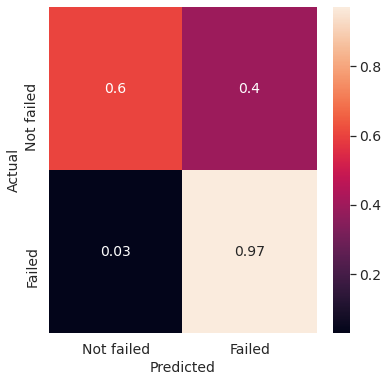

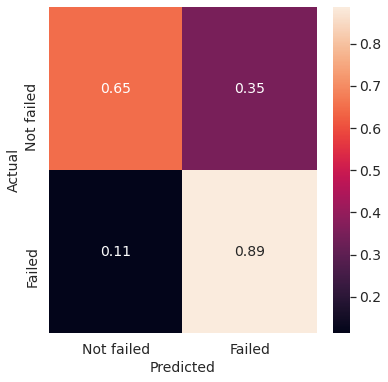

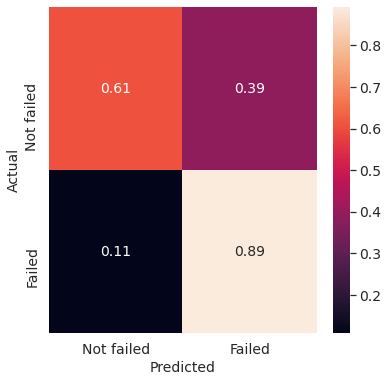

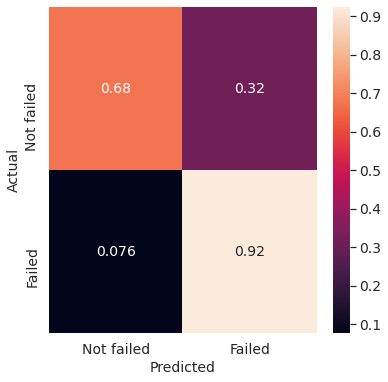

In [99]:
plotAllModelsResults(testVarResultRF,tePredictedResultRF,predoMaterials.copy(),matPropo)

In [100]:
getImportances(modelsResultRF)

NUM_NODES: Number of nodes using a specific feature. The larger
NUM_AS_ROOT: Number of root nodes using a specific feature. The larger
SUM_SCORE: Sum of the split scores using a specific feature. The larger
MEAN_MIN_DEPTH: Average minimum depth of the first occurence of a feature across all the tree paths. The smaller
Material:  AC  ----------------------------------------------


AttributeError: 'RandomForestModel' object has no attribute 'feature_importances_'

In [95]:
#GBDT
#Test with climate manejo de nulls + optimizar + more trees 
modelsResultB, trPredictedResultB,tePredictedResultB, testVarResultB = trainAllModels(RF=False)

Before intrinsic values cleaning  198694
After intrinsic values cleaning  193348
Total Length of pipes with pressure (GIS) 8918.57  in  193348 records
Total Length of pipes with VALID distance to pressure (GIS) 6969.23  in  141403 records
After cleaning pressures  139477
Total Length of pipes with coordinates (GIS) 6871.76  in  139477 records
MaxLat: 1774083.89002 MinLat: 1727604.1138599997
MaxLong: 5986639.7981 MinLong: 5874217.251150001
After cleaning coordinates  139477


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
After cleaning suburbs  139477
Number of water pipe records  619384
Number of intersections  629931  so 1.7% extra
After cleaning geounits  139395
Started with  AC
Start with  44665
Started with  3707195  monthly values and  44665  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished (after adding climate) with  3707195  monthly values and  44665  pipes
Finished creating the transformed data ---------------------------
Started forest with (training)  3171215  monthly values and  44665  pipes
Started forest with (test)  535980  monthly values and  44665  pipes
49551/49551 [==============================] - 203s 4ms/step
Eval:  [0.0, 2212.0, 846404.0, 1359800.0, 304.0, 0.6166521906852722, 0.0026065970305353403, 0.8791732788085938, 0.8249903321266174, 0.005796791985630989]
Finish training with features : ["Diameter" (1; #0), "LAT" (1; #1), "LONG" (1; #2), "MaxPressure" (1; #3), "Month" (4; #4), "MonthsOld" (1; #5), "Past6MonthsTFail" (1; #6), "PressureFluc" (1; #7), "Rain" (1; #8), "SMD" (1; #9), "Shape_Leng" (1; #10), "SoilMainRock" (4; #11), "Suburb" (4; #12), "Temperature" (1; #13), "YearCos" (1; #14), "YearSin" (1; #15)]
Started with  PVC
Start with  28276
Started with  2346908  monthly values and  28276  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished (after adding climate) with  2346908  monthly values and  28276  pipes
Finished creating the transformed data ---------------------------
Started forest with (training)  2000617  monthly values and  28276  pipes
Started forest with (test)  339312  monthly values and  28276  pipes
31260/31260 [==============================] - 130s 4ms/step
Eval:  [0.0, 2541.0, 935724.0, 1609361.0, 406.0, 0.6326066255569458, 0.002708190120756626, 0.8622328042984009, 0.8198230862617493, 0.005625557154417038]
Finish training with features : ["Diameter" (1; #0), "LAT" (1; #1), "LONG" (1; #2), "MaxPressure" (1; #3), "Month" (4; #4), "MonthsOld" (1; #5), "Past6MonthsTFail" (1; #6), "PressureFluc" (1; #7), "Rain" (1; #8), "SMD" (1; #9), "Shape_Leng" (1; #10), "SoilMainRock" (4; #11), "Suburb" (4; #12), "Temperature" (1; #13), "YearCos" (1; #14), "YearSin" (1; #15)]
Started with  Iron
Start with  31198
Started with  2589434  monthly values and  31198  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished (after adding climate) with  2589434  monthly values and  31198  pipes
Finished creating the transformed data ---------------------------
Started forest with (training)  2207857  monthly values and  31198  pipes
Started forest with (test)  374376  monthly values and  31198  pipes
34498/34498 [==============================] - 157s 5ms/step
Eval:  [0.0, 2693.0, 1071187.0, 1848089.0, 439.0, 0.6333072185516357, 0.0025077289901673794, 0.8598339557647705, 0.8213475942611694, 0.005463901441544294]
Finish training with features : ["Diameter" (1; #0), "LAT" (1; #1), "LONG" (1; #2), "MaxPressure" (1; #3), "Month" (4; #4), "MonthsOld" (1; #5), "Past6MonthsTFail" (1; #6), "PressureFluc" (1; #7), "Rain" (1; #8), "SMD" (1; #9), "Shape_Leng" (1; #10), "SoilMainRock" (4; #11), "Suburb" (4; #12), "Temperature" (1; #13), "YearCos" (1; #14), "YearSin" (1; #15)]
Started with  PE
Start with  35256
Started with  2926248  monthly values and  35256  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished (after adding climate) with  2926248  monthly values and  35256  pipes
Finished creating the transformed data ---------------------------
Started forest with (training)  2376866  monthly values and  35256  pipes
Started forest with (test)  423072  monthly values and  35256  pipes
37139/37139 [==============================] - 167s 4ms/step
Eval:  [0.0, 2907.0, 1165160.0, 2176918.0, 495.0, 0.6515731811523438, 0.0024887272156774998, 0.8544973731040955, 0.8272949457168579, 0.005450649186968803]
Finish training with features : ["Diameter" (1; #0), "LAT" (1; #1), "LONG" (1; #2), "MaxPressure" (1; #3), "Month" (4; #4), "MonthsOld" (1; #5), "Past6MonthsTFail" (1; #6), "PressureFluc" (1; #7), "Rain" (1; #8), "SMD" (1; #9), "Shape_Leng" (1; #10), "SoilMainRock" (4; #11), "Suburb" (4; #12), "Temperature" (1; #13), "YearCos" (1; #14), "YearSin" (1; #15)]


size test 535980  vs predict  535980
Fails predicted (True Positives):  737
False fails (False Positives):  25412
Not Fails (True Negatives):  18515
Fails not predicted (False Negatives):  1
Total fails:  738
Target replaced KM 43.77678131691901
size test 339312  vs predict  339312
Fails predicted (True Positives):  366
False fails (False Positives):  8906
Not Fails (True Negatives):  18972
Fails not predicted (False Negatives):  32
Total fails:  398
Target replaced KM 23.423970139747873
size test 374376  vs predict  374376
Fails predicted (True Positives):  165
False fails (False Positives):  13956
Not Fails (True Negatives):  17066
Fails not predicted (False Negatives):  11
Total fails:  176
Target replaced KM 9.016514198918829
size test 423072  vs predict  423072
Fails predicted (True Positives):  223
False fails (False Positives):  9618
Not Fails (True Negatives):  25402
Fails not predicted (False Negatives):  13
Total fails:  236
Target replaced KM 15.508988015292424


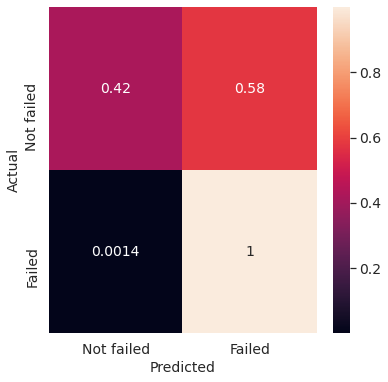

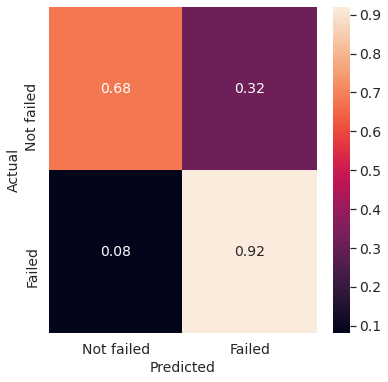

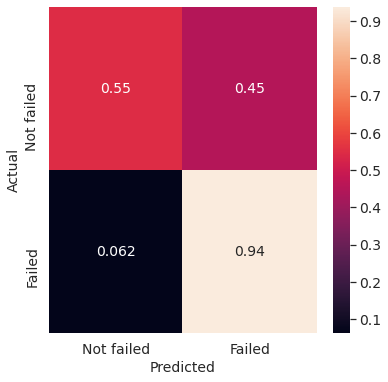

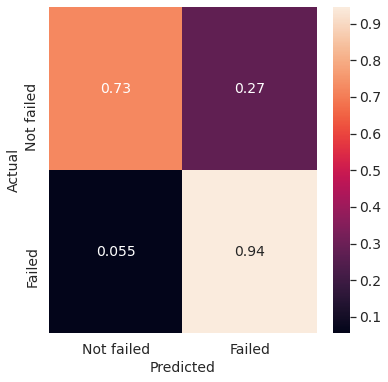

In [97]:
plotAllModelsResults(testVarResultB,tePredictedResultB,predoMaterials.copy(),matPropo,False)

In [91]:
getImportances(modelsResultB)

NUM_NODES: Number of nodes using a specific feature. The larger
NUM_AS_ROOT: Number of root nodes using a specific feature. The larger
SUM_SCORE: Sum of the split scores using a specific feature. The larger
MEAN_MIN_DEPTH: Average minimum depth of the first occurence of a feature across all the tree paths. The smaller
Material:  AC  ----------------------------------------------
                          NUM_NODES
var                                
(Suburb, 4, 12)               216.0
(Shape_Leng, 1, 10)           134.0
(Month, 4, 4)                  40.0
(MaxPressure, 1, 3)            35.0
(Diameter, 1, 0)               34.0
(Past6MonthsTFail, 1, 6)       26.0
(Temperature, 1, 13)           23.0
(MonthsOld, 1, 5)              18.0
(LONG, 1, 2)                   14.0
(PressureFluc, 1, 7)           14.0
(YearCos, 1, 14)               12.0
(YearSin, 1, 15)                8.0
(LAT, 1, 1)                     7.0
(SoilMainRock, 4, 11)           7.0
(Rain, 1, 8)                    6.0
(SMD, 

# Test models parameters ----------------

In [28]:
modelsResult, trPredictedResult,tePredictedResult, testVarResult= trainAllModels(RF=False)

Before intrinsic values cleaning  198694
After intrinsic values cleaning  193349
Total Length of pipes with pressure (GIS) 8918.63  in  193349 records
Total Length of pipes with VALID distance to pressure (GIS) 6969.29  in  141404 records
After cleaning pressures  139478
Total Length of pipes with coordinates (GIS) 6871.81  in  139478 records
MaxLat: 1774083.89002 MinLat: 1727604.1138599997
MaxLong: 5986639.7981 MinLong: 5874217.251150001
After cleaning coordinates  139478


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
After cleaning suburbs  139478
Number of water pipe records  619384
Number of intersections  629931  so 1.7% extra
After cleaning geounits  139396
Started with  AC
Start with  44665
Started with  3707195  monthly values and  44665  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished creating the transformed data ---------------------------
Started forest with (training)  3171215  monthly values and  44665  pipes
Started forest with (test)  535980  monthly values and  44665  pipes
40848/49551 [=======================>......] - ETA: 33s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



size test 535980  vs predict  535980
Not Fails (True Negatives):  23246
False fails (False Positives):  20681
Fails not predicted (False Negatives):  18
Fails predicted (True Positives):  720
Total fails:  738
Target replaced KM 43.77678131691901


IndexError: list index out of range

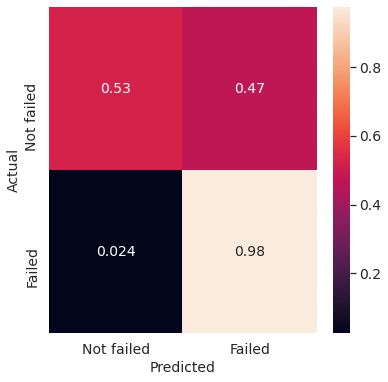

In [29]:
#GRadient descent
#Test with climate manejo de nulls + optimizar + more trees 
plotAllModelsResults(testVarResult,tePredictedResult,predoMaterials.copy(),matPropo)

size test 535980  vs predict  535980
Not Fails (True Negatives):  15668
False fails (False Positives):  28259
Fails not predicted (False Negatives):  1
Fails predicted (True Positives):  737
Total fails:  738
Target replaced KM 43.77678131691901


IndexError: list index out of range

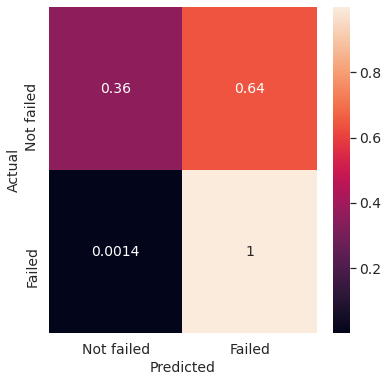

In [26]:
#GRadient descent
#Test with climate manejo de nulls + optimizar + more trees + sparse somehting
plotAllModelsResults(testVarResult,tePredictedResult,predoMaterials.copy(),matPropo)

size test 535980  vs predict  535980
Not Fails (True Negatives):  28303
False fails (False Positives):  15624
Fails not predicted (False Negatives):  28
Fails predicted (True Positives):  710
Total fails:  738
Target replaced KM 43.77678131691901


IndexError: list index out of range

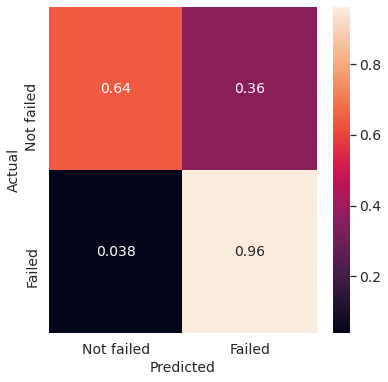

In [23]:
#Random forest
#Test with climate manejo de nulls + optimizar + more trees + sparse somehting
plotAllModelsResults(testVarResult,tePredictedResult,predoMaterials.copy(),matPropo)

size test 535980  vs predict  535980
Not Fails (True Negatives):  26470
False fails (False Positives):  17457
Fails not predicted (False Negatives):  22
Fails predicted (True Positives):  716
Total fails:  738
Target replaced KM 43.77678131691901


IndexError: list index out of range

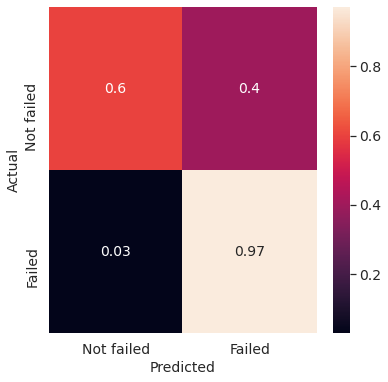

In [38]:
#Test with climate manejo de nulls + optimizar + more trees
plotAllModelsResults(testVarResult,tePredictedResult,predoMaterials.copy(),matPropo)

size test 535980  vs predict  535980
Not Fails (True Negatives):  26478
False fails (False Positives):  17449
Fails not predicted (False Negatives):  29
Fails predicted (True Positives):  709
Total fails:  738
Target replaced KM 43.77678131691901


IndexError: list index out of range

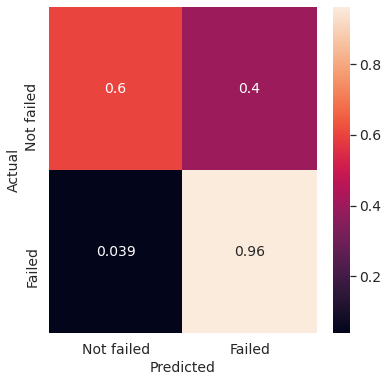

In [35]:
#Test with climate manejo de nulls + optimizar
plotAllModelsResults(testVarResult,tePredictedResult,predoMaterials.copy(),matPropo)

size test 535980  vs predict  535980
Not Fails (True Negatives):  37493
False fails (False Positives):  6434
Fails not predicted (False Negatives):  352
Fails predicted (True Positives):  386
Total fails:  738
Target replaced KM 43.77678131691901


IndexError: list index out of range

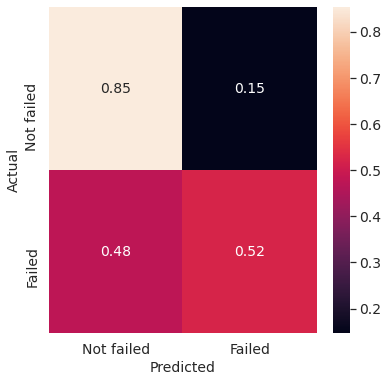

In [32]:
#Test with climate manejo de nulls 
plotAllModelsResults(testVarResult,tePredictedResult,predoMaterials.copy(),matPropo)

size test 535980  vs predict  535980
Not Fails (True Negatives):  37855
False fails (False Positives):  6072
Fails not predicted (False Negatives):  362
Fails predicted (True Positives):  376
Total fails:  738
Target replaced KM 43.77678131691901


IndexError: list index out of range

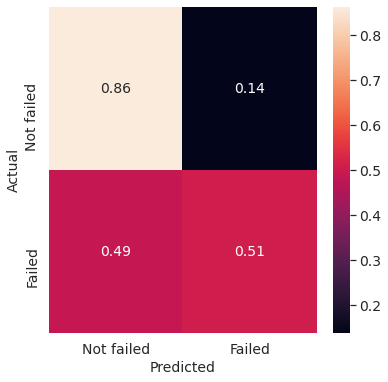

In [25]:
#Test with climate (inside climate without deleting nulls, defaut manejo de nulls)
#Removing Year and COMPKEY
plotAllModelsResults(testVarResult,tePredictedResult,predoMaterials.copy(),matPropo)

size test 535980  vs predict  535980
Not Fails (True Negatives):  37859
False fails (False Positives):  6068
Fails not predicted (False Negatives):  331
Fails predicted (True Positives):  407
Total fails:  738
Target replaced KM 43.77678131691901


IndexError: list index out of range

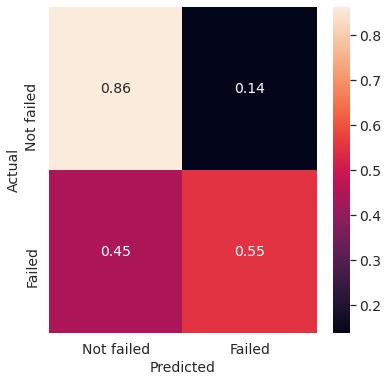

In [50]:
#Test with climate (inside climate without deleting nulls, defaut manejo de nulls)
#Remove YEar
plotAllModelsResults(testVarResult,tePredictedResult,predoMaterials.copy(),matPropo)

size test 535980  vs predict  535980
Not Fails (True Negatives):  37040
False fails (False Positives):  6887
Fails not predicted (False Negatives):  304
Fails predicted (True Positives):  434
Total fails:  738
Target replaced KM 43.77678131691901


IndexError: list index out of range

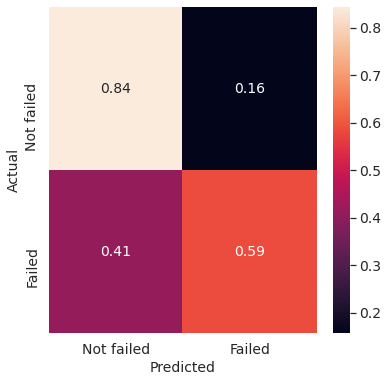

In [39]:
#Test without climate 
plotAllModelsResults(testVarResult,tePredictedResult,predoMaterials.copy(),matPropo)

# OLD BUT GOOD------------

In [38]:
modelsResult, trPredictedResult,tePredictedResult, testVarResult= trainAllModels(RF=True)

Before intrinsic values cleaning  198694
After intrinsic values cleaning  193447
Total Length of pipes with pressure (GIS) 8923.21  in  193447 records
Total Length of pipes with VALID distance to pressure (GIS) 6973.87  in  141502 records
After cleaning pressures  139576
Total Length of pipes with coordinates (GIS) 6876.40  in  139576 records
MaxLat: 1774083.89002 MinLat: 1727604.1138599997
MaxLong: 5986639.7981 MinLong: 5874217.251150001
After cleaning coordinates  139576


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
After cleaning suburbs  139576
Number of water pipe records  619384
Number of intersections  629931  so 1.7% extra
After cleaning geounits  139494
Started with  AC
Start with  44763
Started with  3715329  monthly values and  44763  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished creating the transformed data ---------------------------
Columns in the training dataset:  ['Shape_Leng', DIAMETER, 'MaxPressure', 'PressureFluc', 'LAT', 'LONG', SUBURB, 'SoilMainRock', 'MonthsOld', 'Past6MonthsTFail', 'Failed', 'weights', 'YearSin', 'YearCos']
Started forest with (training)  3178173  monthly values and  44763  pipes
Started forest with (test)  537156  monthly values and  44763  pipes
49659/49659 [==============================] - 153s 3ms/step
Eval:  [0.0, 3785.0, 1422969.0, 4130037.0, 2149.0, 0.7436349391937256, 0.0026528749149292707, 0.6378496885299683, 0.7793837189674377, 0.005886164493858814]
Started with  PVC
Start with  28277
Started with  2346991  monthly values and  28277  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished creating the transformed data ---------------------------
Columns in the training dataset:  ['Shape_Leng', DIAMETER, 'MaxPressure', 'PressureFluc', 'LAT', 'LONG', SUBURB, 'SoilMainRock', 'MonthsOld', 'Past6MonthsTFail', 'Failed', 'weights', 'YearSin', 'YearCos']
Started forest with (training)  2000688  monthly values and  28277  pipes
Started forest with (test)  339324  monthly values and  28277  pipes
31261/31261 [==============================] - 100s 3ms/step
Eval:  [0.0, 3926.0, 1442700.0, 4449199.0, 2439.0, 0.7549890875816345, 0.002713901223614812, 0.61681067943573, 0.7764681577682495, 0.005697138607501984]
Started with  Iron
Start with  31198
Started with  2589434  monthly values and  31198  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished creating the transformed data ---------------------------
Columns in the training dataset:  ['Shape_Leng', DIAMETER, 'MaxPressure', 'PressureFluc', 'LAT', 'LONG', SUBURB, 'SoilMainRock', 'MonthsOld', 'Past6MonthsTFail', 'Failed', 'weights', 'YearSin', 'YearCos']
Started forest with (training)  2207857  monthly values and  31198  pipes
Started forest with (test)  374376  monthly values and  31198  pipes
34498/34498 [==============================] - 110s 3ms/step
Eval:  [0.0, 3951.0, 1448716.0, 4817374.0, 2599.0, 0.7686277031898499, 0.0027198249008506536, 0.6032060980796814, 0.77879399061203, 0.0055939513258636]
Started with  PE
Start with  35256
Started with  2926248  monthly values and  35256  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished creating the transformed data ---------------------------
Columns in the training dataset:  ['Shape_Leng', DIAMETER, 'MaxPressure', 'PressureFluc', 'LAT', 'LONG', SUBURB, 'SoilMainRock', 'MonthsOld', 'Past6MonthsTFail', 'Failed', 'weights', 'YearSin', 'YearCos']
Started forest with (training)  2376866  monthly values and  35256  pipes
Started forest with (test)  423072  monthly values and  35256  pipes
37139/37139 [==============================] - 119s 3ms/step
Eval:  [0.0, 4032.0, 1457464.0, 5231428.0, 2788.0, 0.7819123864173889, 0.002758817048743367, 0.5912023186683655, 0.7823281288146973, 0.005491672549396753]


In [26]:
modelsResultNRF, trPredictedResultNRF,tePredictedResultNRF, testVarResultNRF= trainAllModels(RF=False)

Before intrinsic values cleaning  198694
After intrinsic values cleaning  193447
Total Length of pipes with pressure (GIS) 8923.21  in  193447 records
Total Length of pipes with VALID distance to pressure (GIS) 6973.87  in  141502 records
After cleaning pressures  139576
Total Length of pipes with coordinates (GIS) 6876.40  in  139576 records
MaxLat: 1774083.89002 MinLat: 1727604.1138599997
MaxLong: 5986639.7981 MinLong: 5874217.251150001
After cleaning coordinates  139576


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
After cleaning suburbs  139576
Number of water pipe records  619384
Number of intersections  629931  so 1.7% extra
After cleaning geounits  139494
Started with  AC
Start with  44763
Started with  3715329  monthly values and  44763  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished creating the transformed data ---------------------------
Columns in the training dataset:  ['Shape_Leng', DIAMETER, 'MaxPressure', 'PressureFluc', 'LAT', 'LONG', SUBURB, 'SoilMainRock', 'MonthsOld', 'Past6MonthsTFail', 'Failed', 'weights', 'YearSin', 'YearCos']
Started forest with (training)  3178173  monthly values and  44763  pipes
Started forest with (test)  537156  monthly values and  44763  pipes
49659/49659 [==============================] - 154s 3ms/step
Eval:  [0.0, 2685.0, 902685.0, 2978098.0, 1544.0, 0.7672519683837891, 0.0029656384140253067, 0.6349018812179565, 0.789936363697052, 0.00602986104786396]
Started with  PVC
Start with  28277
Started with  2346991  monthly values and  28277  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished creating the transformed data ---------------------------
Columns in the training dataset:  ['Shape_Leng', DIAMETER, 'MaxPressure', 'PressureFluc', 'LAT', 'LONG', SUBURB, 'SoilMainRock', 'MonthsOld', 'Past6MonthsTFail', 'Failed', 'weights', 'YearSin', 'YearCos']
Started forest with (training)  2000688  monthly values and  28277  pipes
Started forest with (test)  339324  monthly values and  28277  pipes
31261/31261 [==============================] - 96s 3ms/step
Eval:  [0.0, 3032.0, 1008370.0, 3211306.0, 1628.0, 0.7609096169471741, 0.0029978188686072826, 0.6506437659263611, 0.7915247678756714, 0.006010579876601696]
Started with  Iron
Start with  31198
Started with  2589434  monthly values and  31198  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished creating the transformed data ---------------------------
Columns in the training dataset:  ['Shape_Leng', DIAMETER, 'MaxPressure', 'PressureFluc', 'LAT', 'LONG', SUBURB, 'SoilMainRock', 'MonthsOld', 'Past6MonthsTFail', 'Failed', 'weights', 'YearSin', 'YearCos']
Started forest with (training)  2207857  monthly values and  31198  pipes
Started forest with (test)  374376  monthly values and  31198  pipes
34498/34498 [==============================] - 112s 3ms/step
Eval:  [0.0, 3211.0, 1290205.0, 3303662.0, 1634.0, 0.719086766242981, 0.0024825732689350843, 0.6627451181411743, 0.7774128317832947, 0.005748880561441183]
Started with  PE
Start with  35256
Started with  2926248  monthly values and  35256  pipes


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Finished creating the transformed data ---------------------------
Columns in the training dataset:  ['Shape_Leng', DIAMETER, 'MaxPressure', 'PressureFluc', 'LAT', 'LONG', SUBURB, 'SoilMainRock', 'MonthsOld', 'Past6MonthsTFail', 'Failed', 'weights', 'YearSin', 'YearCos']
Started forest with (training)  2376866  monthly values and  35256  pipes
Started forest with (test)  423072  monthly values and  35256  pipes
12813/37139 [=========>....................] - ETA: 1:20

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Eval:  [0.0, 3415.0, 1365291.0, 3651378.0, 1700.0, 0.7277877926826477, 0.002495057415217161, 0.667644202709198, 0.7846727967262268, 0.006240238435566425]


size test 537156  vs predict  537156
Not Fails (True Negatives):  37059
False fails (False Positives):  6963
Fails not predicted (False Negatives):  301
Fails predicted (True Positives):  440
Total fails:  741
Target replaced KM 43.77678131691901
size test 339384  vs predict  339384
Not Fails (True Negatives):  25440
False fails (False Positives):  2444
Fails not predicted (False Negatives):  225
Fails predicted (True Positives):  173
Total fails:  398
Target replaced KM 23.423970139747873
size test 374376  vs predict  374376
Not Fails (True Negatives):  29757
False fails (False Positives):  1265
Fails not predicted (False Negatives):  138
Fails predicted (True Positives):  38
Total fails:  176
Target replaced KM 9.016514198918829
size test 423072  vs predict  423072
Not Fails (True Negatives):  33526
False fails (False Positives):  1494
Fails not predicted (False Negatives):  146
Fails predicted (True Positives):  90
Total fails:  236
Target replaced KM 15.508988015292424


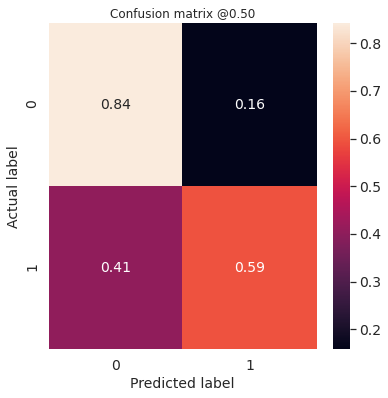

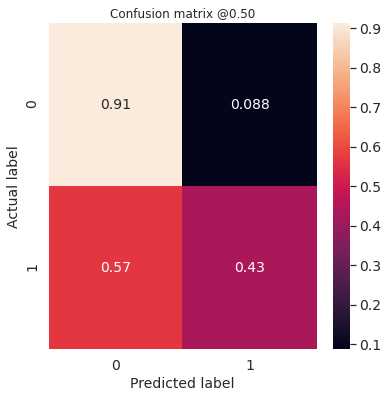

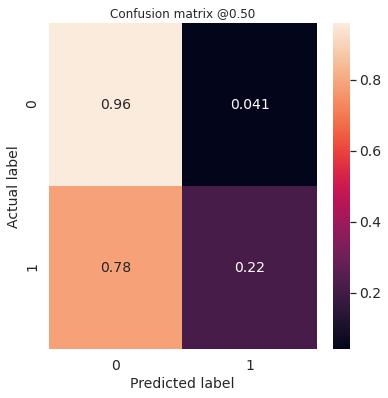

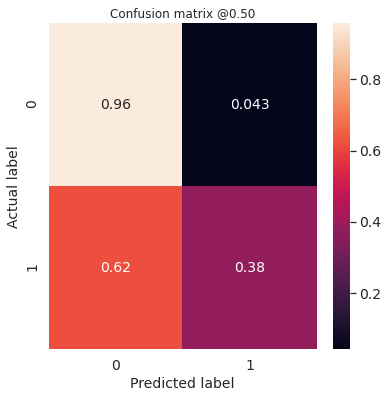

In [321]:
#Results with coordinates, year, month and with 6 months previous in numbers Higher tolerance to pressure far 5m
plotAllModelsResults(testVA,tePredA,predoMaterials.copy(),matPropo) 

size test 537156  vs predict  537156
Not Fails (True Negatives):  27487
False fails (False Positives):  16535
Fails not predicted (False Negatives):  9
Fails predicted (True Positives):  732
Total fails:  741
Target replaced KM 43.77678131691901
size test 339324  vs predict  339324
Not Fails (True Negatives):  18274
False fails (False Positives):  9605
Fails not predicted (False Negatives):  23
Fails predicted (True Positives):  375
Total fails:  398
Target replaced KM 23.423970139747873
size test 374376  vs predict  374376
Not Fails (True Negatives):  7133
False fails (False Positives):  23889
Fails not predicted (False Negatives):  4
Fails predicted (True Positives):  172
Total fails:  176
Target replaced KM 9.016514198918829
size test 423072  vs predict  423072
Not Fails (True Negatives):  26052
False fails (False Positives):  8968
Fails not predicted (False Negatives):  2
Fails predicted (True Positives):  234
Total fails:  236
Target replaced KM 15.508988015292424


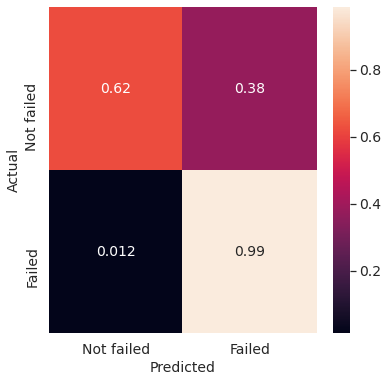

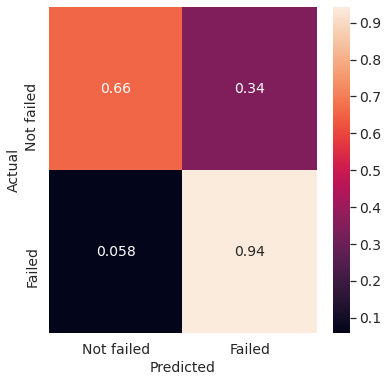

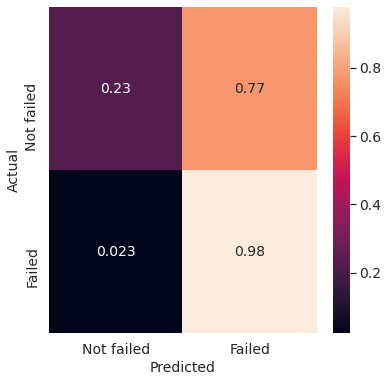

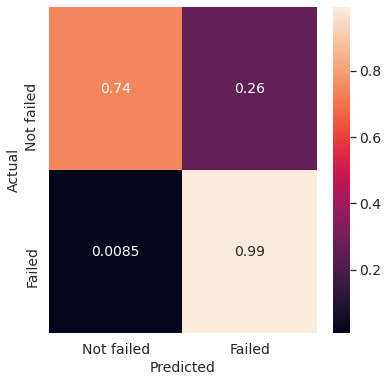

In [36]:
plotAllModelsResults(testVarResultNRF,tePredictedResultNRF,predoMaterials.copy(),matPropo,False)

size test 537156  vs predict  537156
Not Fails (True Negatives):  37059
False fails (False Positives):  6963
Fails not predicted (False Negatives):  301
Fails predicted (True Positives):  440
Total fails:  741
Target replaced KM 43.77678131691901
size test 339324  vs predict  339324
Not Fails (True Negatives):  25379
False fails (False Positives):  2500
Fails not predicted (False Negatives):  227
Fails predicted (True Positives):  171
Total fails:  398
Target replaced KM 23.423970139747873
size test 374376  vs predict  374376
Not Fails (True Negatives):  29757
False fails (False Positives):  1265
Fails not predicted (False Negatives):  138
Fails predicted (True Positives):  38
Total fails:  176
Target replaced KM 9.016514198918829
size test 423072  vs predict  423072
Not Fails (True Negatives):  33526
False fails (False Positives):  1494
Fails not predicted (False Negatives):  146
Fails predicted (True Positives):  90
Total fails:  236
Target replaced KM 15.508988015292424


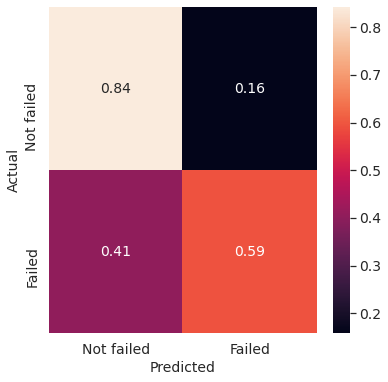

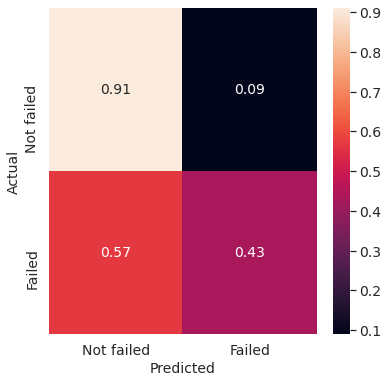

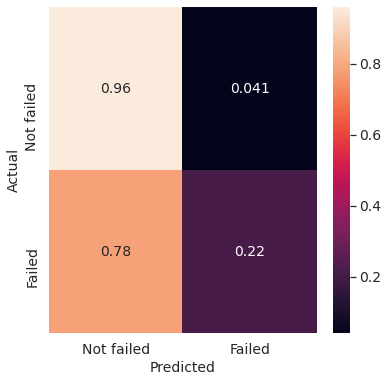

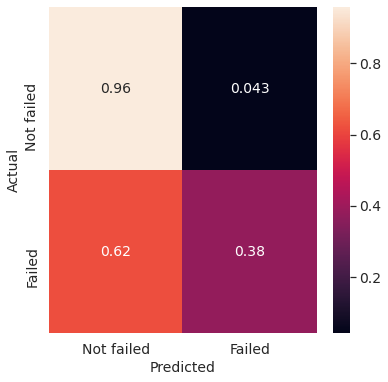

In [41]:
plotAllModelsResults(testVarResult,tePredictedResult,predoMaterials.copy(),matPropo)

In [46]:
getImportances(modelsResult)

NUM_NODES: Number of nodes using a specific feature. The larger
NUM_AS_ROOT: Number of root nodes using a specific feature. The larger
SUM_SCORE: Sum of the split scores using a specific feature. The larger
MEAN_MIN_DEPTH: Average minimum depth of the first occurence of a feature across all the tree paths. The smaller
Material:  AC  ----------------------------------------------
                          NUM_AS_ROOT
var                                  
(Shape_Leng, 1, 11)              92.0
(Suburb, 4, 13)                  79.0
(Past6MonthsTFail, 1, 7)         55.0
(Diameter, 1, 1)                 23.0
(Year, 1, 15)                    23.0
(LONG, 1, 3)                      9.0
(LAT, 1, 2)                       4.0
(Rain, 1, 9)                      3.0
(YearSin, 1, 17)                  3.0
(MonthsOld, 1, 6)                 2.0
(SMD, 1, 10)                      2.0
(SoilMainRock, 4, 12)             2.0
(MaxPressure, 1, 4)               1.0
(Month, 1, 5)                     1.0
(Temperatu

In [43]:
#Results with climate and with 6 months previous
#modelsResultNRF, trPredictedResultNRF,tePredictedResultNRF, testVarResultNRF
getImportances(modelsResultNRF)

NUM_NODES: Number of nodes using a specific feature. The larger
NUM_AS_ROOT: Number of root nodes using a specific feature. The larger
SUM_SCORE: Sum of the split scores using a specific feature. The larger
MEAN_MIN_DEPTH: Average minimum depth of the first occurence of a feature across all the tree paths. The smaller
Material:  AC  ----------------------------------------------
                          NUM_AS_ROOT
var                                  
(Past6MonthsTFail, 1, 5)         11.0
(Shape_Leng, 1, 7)                9.0
(Diameter, 1, 0)                  6.0
(Suburb, 4, 9)                    2.0
                             SUM_SCORE
var                                   
(Shape_Leng, 1, 7)        1.536187e+06
(Suburb, 4, 9)            1.055251e+06
(Diameter, 1, 0)          6.779995e+05
(Past6MonthsTFail, 1, 5)  6.582308e+05
(MaxPressure, 1, 3)       5.523732e+04
(YearSin, 1, 11)          2.685642e+04
(LAT, 1, 1)               2.392327e+04
(PressureFluc, 1, 6)      1.984020e+04


In [234]:
from IPython.display import IFrame

with open('./plot_model.html', 'w') as f:
    f.write(tfdf.model_plotter.plot_model(modelsResult[0]))
            

IFrame('./plot_model.html', width = 900, height = 700)

In [235]:
with open('./plot_model.html', 'w') as f:
    f.write(tfdf.model_plotter.plot_model(modelsResult[1]))
            

IFrame('./plot_model.html', width = 900, height = 700)

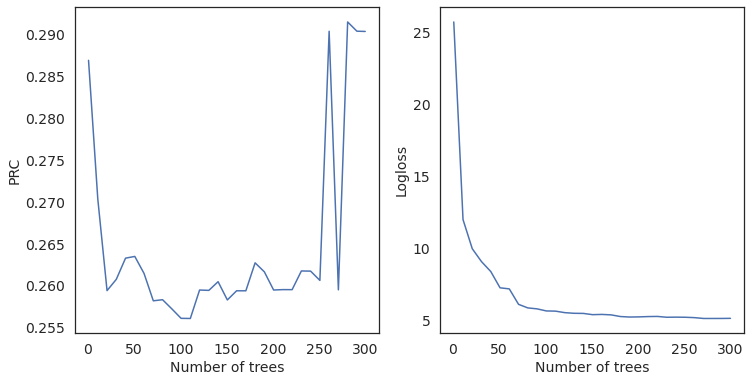

In [104]:
def plotIterations(model):

    logs = model.make_inspector().training_logs()

    fig1, [ax,ax1] = plt.subplots(1,2,figsize=(12,6))

    
    ax.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    ax.set_xlabel("Number of trees")
    ax.set_ylabel("PRC")
    
    ax1.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    ax1.set_xlabel("Number of trees")
    ax1.set_ylabel("Logloss")
    


plotIterations(mod)

In [128]:
from IPython.display import display, HTML
    
tree= tfdf.model_plotter.plot_model(mod)
